In [1]:
import torch
import torch.nn as nn

import matplotlib.pyplot as plt

import time
from math import exp
from tqdm import tqdm

from rbm.lattices import Fine_RBM, A1_RBM
from rg.monotone import MLP
from utils.losses import free_energy_contrast
from utils.newton import find_root
from utils.hmc import HMC
from utils.grad import batch_grad, grad

In [2]:
device = torch.device('cpu')

In [3]:
def plot(f, xlim=(0, 2)):
    
    x_vals = torch.linspace(*xlim, 100, device=device).unsqueeze(1)
    
    f_vals = f(x_vals).cpu().detach()
    dfdx_vals = batch_grad(f)(x_vals).cpu().detach()
    x_vals = x_vals.cpu().detach()

    fig, (ax0, ax1) = plt.subplots(2, 1, sharex=True, figsize=(8, 4))
    
    ax0.plot(x_vals, f_vals)
    ax0.set_ylabel(r'$f$')
    
    ax1.plot(x_vals, dfdx_vals)
    ax1.set_xlabel(r'$x$')
    ax1.set_ylabel(r'$\nabla \: f$')
    ax1.axhline(0, color='black', linewidth=0.5)
    ax1.axvline(0, color='black', linewidth=0.5)

# Models

In [4]:
C = MLP(
    in_channels=1, 
    device=device
)
C.eval();

In [5]:
fine = Fine_RBM(device=device)
coarse = A1_RBM(device=device)

In [6]:
sampler = HMC(device=device)

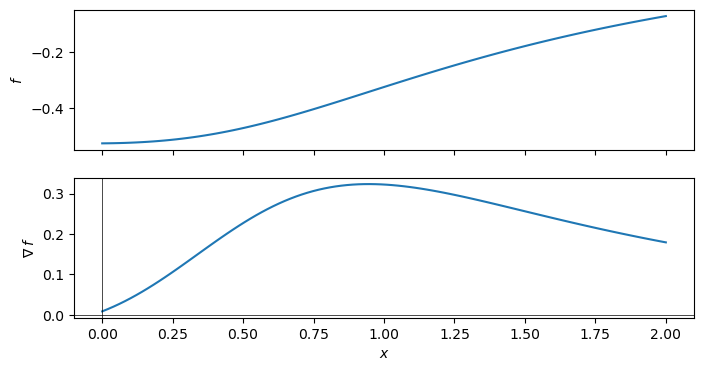

In [7]:
plot(C)

In [8]:
C.mlp[0].weight.mean()

tensor(-0.0459, grad_fn=<MeanBackward0>)

# Training

In [9]:
epoch = 0
epochs = 2048
batch_size = 1024
k = 64
beta = lambda epoch : 4/(1 + exp(-0.01 * (epoch - (epochs / 2))))

In [10]:
optimizer = torch.optim.Adam(C.parameters())

Js = []
losses = []
J = torch.tensor([1.], device=device)

100%|███████████████████████████████████████| 2048/2048 [00:47<00:00, 42.82it/s]


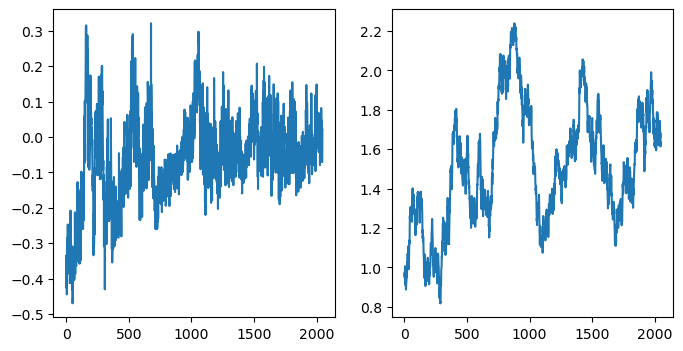

In [11]:
C.train()

for epoch in tqdm(range(epoch, epoch + epochs)):
    optimizer.zero_grad()

    sampler.potential = lambda J : -beta(epoch) * grad(C)(J).squeeze().norm()

    # RG Flow
    J = torch.clamp(sampler.step(J), min=0).detach()
    fine.J = J
    coarse.J = J - grad(C)(J)

    # Loss
    loss = free_energy_contrast(
        fine, coarse, 
        batch_size=batch_size, 
        k_fine=64, 
        k_coarse=1
    )
    loss.backward()
    optimizer.step()

    # Logging
    Js.append(float(J))
    losses.append(float(loss))

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(8, 4))
ax0.plot(losses)
ax1.plot(Js)

0.5247016549110413

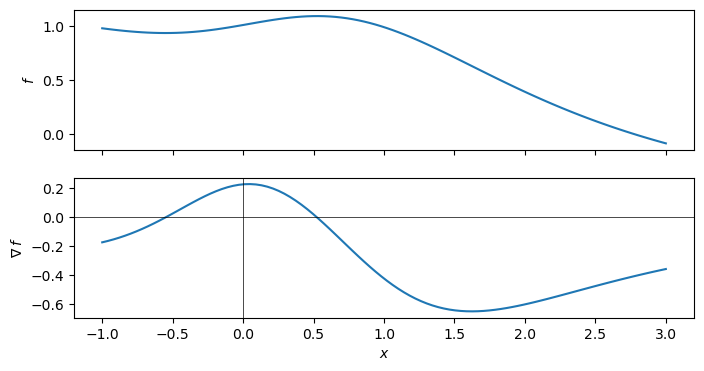

In [12]:
C.eval()
plot(C, xlim=(-1, 3))
find_root(torch.tensor([1.], device=device), lambda x: grad(C)(x).squeeze())